#### Get data

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

import statsmodels.api as sm

In [92]:
input_file = "reg_combined_df.csv"
full_data_raw = pd.read_csv(input_file, index_col=0)
full_data = full_data_raw.copy()

In [93]:
# Obtain income data by number of thousands
full_data["income"] = full_data["income"] / 1000
full_data = full_data.rename(columns={"income": "income_k"})

# Obtain time_since_last_txn in terms of days
full_data["time_since_last_txn"] = round((full_data["time_since_last_txn"] / 24), 2)

#### Check & Split data

In [94]:
# Check differences in values for numeric columns between the 2 responses (0/1)
def check_num_cols_mean(data):
    numeric_cols_df = data.select_dtypes('number')
    return numeric_cols_df.groupby("offer_completed").mean().round(2)

In [95]:
check_num_cols_mean(full_data)

,age,income_k,reward,difficulty,duration,num_channels,used_email,used_web,used_social,used_mobile,offer_viewed,received_time,time_since_last_txn,last_txn_amt,ave_txn_amt,num_txn_past_week,num_offers_past_week
offer_completed,,,,,,,,,,,,,,,,,
0,52.98,61.50,3.48,6.19,5.73,3.17,1.0,0.72,0.55,0.9,0.65,327.15,11.26,8.13,8.01,1.50,0.86
1,55.83,69.43,4.95,9.31,7.32,3.43,1.0,0.89,0.65,0.9,0.82,338.34,8.56,14.29,14.26,1.88,0.89


In [96]:
def plot_cat_count_distribution(data, col):
    count_df = data.groupby(["offer_completed", col])[col].value_counts().reset_index(name="count")
    plt.figure(figsize=(6,4))
    sns.barplot(data=count_df, x="count", y=col, hue="offer_completed")
    plt.show()

# Only checks for gender and offer_type categorical variables
def check_cat_cols_distribution(data):
    cat_cols = data.select_dtypes('object').columns.to_list() + ["offer_completed"]
    cat_cols_df = data[cat_cols]
    plot_cat_count_distribution(cat_cols_df, "gender")
    plot_cat_count_distribution(cat_cols_df, "offer_type")

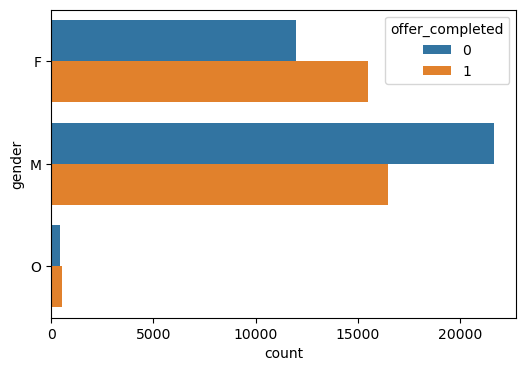

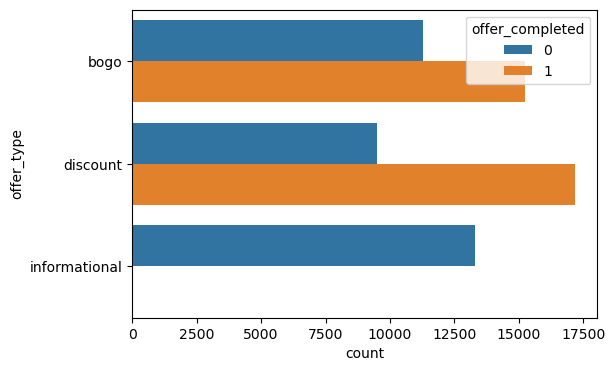

In [97]:
check_cat_cols_distribution(full_data)

- Given that all informational offers were not completed, it could be an indication that this offer type was not meant to be completed.
- As such, all offer records with "informational" offer_type will be removed from the regression dataset. 

In [98]:
# Remove offer records with "informational" offer_type
full_data_rm_info = full_data.copy()[full_data["offer_type"] != "informational"].reset_index(drop=True)

In [99]:
def plot_completion_response_distribution(data):
    count_df = data["offer_completed"].value_counts().reset_index()
    response_label = list(count_df["offer_completed"])
    response_count = list(count_df["count"])
    plt.figure(figsize=(2, 2))
    plt.pie(response_count, labels=response_label, autopct='%1.2f%%')
    plt.show()

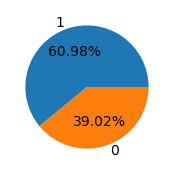

In [100]:
# Overall distribution of response variable in full_data_rm_info
plot_completion_response_distribution(full_data_rm_info)

Num. records excluded (1st week data):  8828
Num. records in filtered dataset:  44373


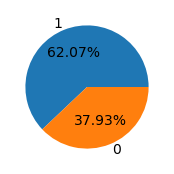

In [101]:
# Exclude data from 1st week
first_wk_data = full_data_rm_info[full_data_rm_info ["received_time"] < (24*7)]
print("Num. records excluded (1st week data): ", len(first_wk_data))
data = full_data_rm_info[full_data_rm_info["received_time"] >= (24*7)].reset_index(drop=True)
print("Num. records in filtered dataset: ", len(data))
# Check distribution of response variable in data after 1st week removal
plot_completion_response_distribution(data)

In [102]:
check_num_cols_mean(data)

,age,income_k,reward,difficulty,duration,num_channels,used_email,used_web,used_social,used_mobile,offer_viewed,received_time,time_since_last_txn,last_txn_amt,ave_txn_amt,num_txn_past_week,num_offers_past_week
offer_completed,,,,,,,,,,,,,,,,,
0,51.84,58.69,5.72,10.18,7.17,3.28,1.0,0.86,0.59,0.84,0.65,398.94,8.11,7.46,7.34,1.70,1.05
1,55.87,69.47,4.96,9.30,7.31,3.43,1.0,0.89,0.64,0.90,0.81,398.56,5.11,16.67,16.63,2.21,1.05


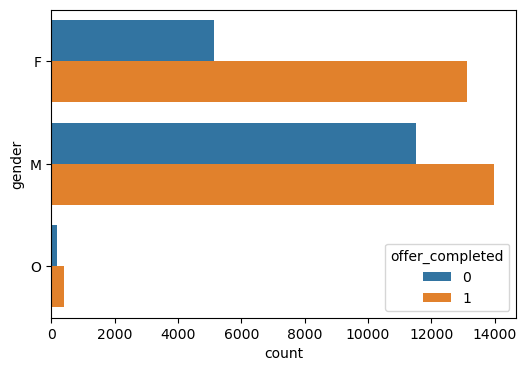

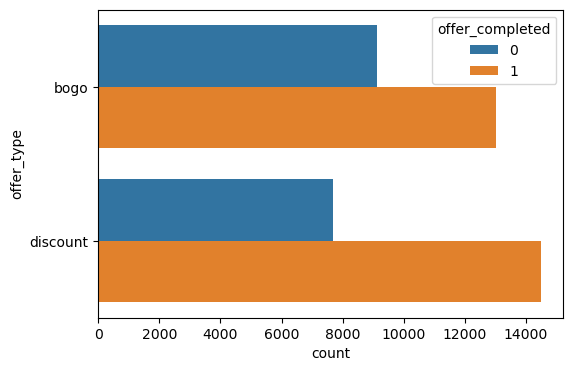

In [103]:
check_cat_cols_distribution(data)

In [104]:
# Train-test-split
training_data = data.copy()
response_var = training_data.pop("offer_completed")
X_train, X_test, y_train, y_test = train_test_split(training_data, response_var, test_size=0.2, random_state=45)

Num. records (train):  35498


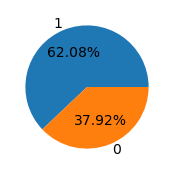


Num. records (test):  8875


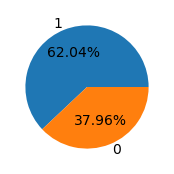

In [105]:
# Check distribution of response variable (train dataset)
print("Num. records (train): ", len(y_train))
plot_completion_response_distribution(y_train.reset_index(name="offer_completed"))

# Check distribution of response variable (test dataset)
print("\nNum. records (test): ", len(y_test))
plot_completion_response_distribution(y_test.reset_index(name="offer_completed"))

#### Logistic Regression (predict offer completion)

- Independent variables should be independent of each other --> avoid multicollinearity
- Independent variables are linearly related of the log odds of customer acting on offer

In [106]:
# Remove columns not needed (person, offer_id, received_time)
X_train = X_train.drop(columns=["person", "offer_id", "received_time"])
X_test= X_test.drop(columns=["person", "offer_id", "received_time"])

# Convert categorical variables to numeric form using one-hot encoding (regression requires all variables to be numeric)
# Drop 1 level of dummmy variable to avoid perfect multicollinearity
X_train = pd.concat([X_train, pd.get_dummies(X_train["gender"], prefix="is", dtype=int, drop_first=True)], axis=1)
X_train = pd.concat([X_train, pd.get_dummies(X_train["offer_type"], prefix="is", dtype=int, drop_first=True)], axis=1)

X_test = pd.concat([X_test, pd.get_dummies(X_test["gender"], prefix="is", dtype=int)], axis=1)
X_test = pd.concat([X_train, pd.get_dummies(X_test["offer_type"], prefix="is", dtype=int)], axis=1)

# Drop original categorical variables
X_train = X_train.drop(columns=["gender", "offer_type"])
X_test = X_test.drop(columns=["gender", "offer_type"])

# Drop num_channels variable due to perfect multicollinearity
# num_channels = used_email + used_web + used_social + used_mobile
X_train = X_train.drop(columns=["num_channels"])
X_test = X_test.drop(columns=["num_channels"])

# X_train.info()

In [107]:
# Obtain regression results
logit_model = sm.Logit(endog=y_train, exog=X_train)
logit_model_results = logit_model.fit()
print(logit_model_results.summary2())

Optimization terminated successfully.
         Current function value: 0.541146
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.185     
Dependent Variable:   offer_completed   AIC:               38455.1759
Date:                 2024-04-18 18:44  BIC:               38607.7661
No. Observations:     35498             Log-Likelihood:    -19210.   
Df Model:             17                LL-Null:           -23560.   
Df Residuals:         35480             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
age                   0.0027   0.0007   3.6334 0.0003  0.0012  0.0041
income_k        

In [108]:
# Perform Recursive Feature Elimination (RFE)
# rfe = RFE(log_reg_model, 20)
# rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)

# Get model performance metrics
# log_reg_model = LogisticRegression(random_state=45)
# log_reg_model.fit(X_train, y_train)